# IMA204 Practical Session - Segmentation of medical images

## Cristian Alejandro Chávez Becerra & Carlos Martín Gruss

We implemented preliminary solutions for both the **Abdominal CT** dataset and the **Brain MRI** dataset.

## Imports

In [1]:
# Standard library imports
import os
import glob
from collections import deque

# Third-party imports for numerical operations
import numpy as np
import cv2
from scipy.io import loadmat
from scipy import ndimage
from scipy.spatial.distance import dice

# Image processing imports from skimage
import skimage
from skimage import data, color, morphology, segmentation, filters, exposure
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.filters import rank, gaussian, threshold_multiotsu
from skimage.segmentation import watershed
from skimage.measure import find_contours
import skimage.morphology as morpho
from skimage.morphology import disk, ellipse, convex_hull_image

# Matplotlib imports for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)

Working_directory =  c:\Users\carlos\Downloads\GitHub\telecom-ima204-segmentation


In [2]:
def my_kmeans(image, k, labels=None):
    #k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                                         labels, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image, segmented_labels


def my_colormap_white_bkg(Colormap_name,numLabels):
    #numLabels = number of colors
    
    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

## Abdominal CT

For this dataset, our implementation works with the images in indexes `0` and `1` reasonably well, although the performance is much better optimized for the example in index `0`. The biggest limitation of this pipeline is that it was designed to work with examples that:

*   Only show one kidney, not two. 
*   Have a tumor. 

Thus, it's not good for the rest of the dataset. More work is needed to continue to improve and generalize this pipeline.

### Function definitions

In [3]:
def load_image(index, directory):
    """ Load the original and segmentation images based on the provided index. """
    list_images = glob.glob(directory + '/*-seg.tiff')
    print(f'There are {len(list_images)} abdominal CT images\n')

    filename_segmentation = list_images[index]
    labels = imread(filename_segmentation)
    filename = filename_segmentation[:-9] + '.tiff'
    image = imread(filename)

    print(f'Reading image {filename}')
    print(f'Labels image {np.unique(labels)}')
    return image, labels

def display_images(images, titles, cmap='gray', size=(5, 5)):
    """ Display images with titles in a subplot. """
    n_images = len(images)
    fig, ax = plt.subplots(1, n_images, figsize=size)

    if n_images == 1:
        ax = [ax]  # Wrap the ax object in a list if there's only one image

    for i in range(n_images):
        ax[i].imshow(images[i], cmap=cmap)
        ax[i].set_title(titles[i])
        ax[i].axis('off')

    fig.tight_layout()
    plt.show()

def prefilter_image(image, size=8, equalize=False, clip_limit=0.03):
    """ Apply median filtering. """
    if equalize:
        image = skimage.exposure.equalize_adapthist(image, clip_limit=clip_limit)*255
    return ndimage.median_filter(image, size=size)

def threshold(image, thresh_val=50, min_size=500, connectivity=1, area_threshold=500):
    """ Apply threshold to image while removing small holes using morphology. """
    thresholded_image = morphology.remove_small_holes(morphology.remove_small_objects(
        image > thresh_val, min_size=min_size, connectivity=connectivity), 
        area_threshold=area_threshold)
    return thresholded_image

def morphological_preprocessing(image, se_height=20, se_width=3, thresh_val=50, min_size=500, connectivity=1, area_threshold=500):
    """ Apply morphological operations to the image. """
    se = ellipse(width=se_width, height=se_height)
    opened_image = morpho.opening(image, se)
    thresholded_image = threshold(opened_image, thresh_val, min_size, connectivity, area_threshold)
    return thresholded_image.astype('uint8')

def keep_smallest_connex_area(binary_image):
    # Check if the image is binary
    if np.unique(binary_image).tolist() not in [[0], [1], [0, 1]]:
        raise ValueError("The image should be binary")

    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image.astype(np.uint8), 8, cv2.CV_32S)

    # Skip the background label
    sizes = stats[1:, cv2.CC_STAT_AREA]
    label_indices = np.arange(1, num_labels)

    # Find the smallest component
    if len(sizes) == 0:
        # No connex areas found, return a zero matrix of the same size
        return np.zeros_like(binary_image)
    smallest_label = label_indices[np.argmin(sizes)]

    # Create an image with only the smallest component
    smallest_connex_area = (labels == smallest_label).astype(np.uint8)
    return smallest_connex_area

def threshold_and_open(image, thresh_val, min_size=500, area_threshold=500, connectivity=1, disk_size=3):
    """ Apply thresholding and opening to the image. """
    thresholded_image = threshold(image, thresh_val, min_size, connectivity, area_threshold)
    return morphology.opening(thresholded_image, morphology.disk(disk_size)).astype('uint8')

def crop_image(image, mask):
    """ Element-wise multiplication of two images. """
    return image * mask

def enhance_contrast(image, clip_limit=0.03):
    return skimage.exposure.equalize_adapthist(image, clip_limit=clip_limit)*255

def binary_threshold(image, label=127):
    """ Convert an image to binary format based on a threshold. """
    return (image == label).astype(int)

def combine_masks(seg_thresh_test_1, seg_thresh_test_2, label_1=127, label_2=255):
    """ Combine results for final image. """
    result = np.zeros_like(seg_thresh_test_1)
    result += label_1 * seg_thresh_test_1 + label_2 * seg_thresh_test_2
    return result

def compute_dice(result, labels_image, label):
    """ Compute DICE simmilarity coefficient between two images. """
    # Convert images to binary if they are not already
    binary_result = binary_threshold(result, label=label)
    binary_ground_truth = binary_threshold(labels_image, label=label)

    # Flatten the images
    flat_result = binary_result.flatten()
    flat_ground_truth = binary_ground_truth.flatten()

    # Compute the Dice coefficient
    dice_sim = 1-dice(flat_result, flat_ground_truth)
    
    return dice_sim

### Load image

Working with `indexIm = 0` and `indexIm = 1`.

There are 6 abdominal CT images

Reading image c:\Users\carlos\Downloads\GitHub\telecom-ima204-segmentation/data/abdominalCT\CTs1.tiff
Labels image [  0 127 255]


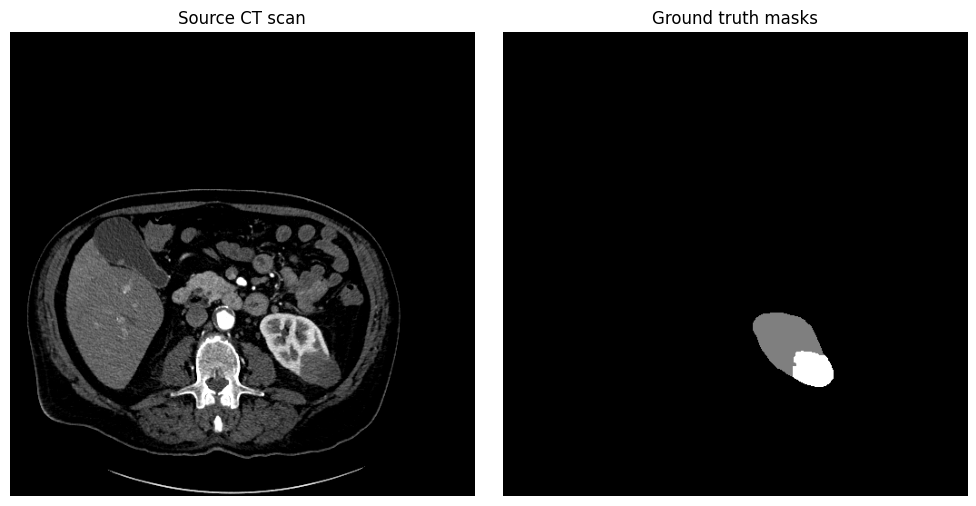

In [4]:
abdominalCT_path = Working_directory + '/data/abdominalCT'
indexIm = 0  # between 0 and 5

original_image, labels_image = load_image(indexIm, abdominalCT_path)
display_images([original_image, labels_image], ['Source CT scan', 'Ground truth masks'], size=(10, 5))

### Hyperparameters

In [5]:
# Pre-processing
PRE_MEDIAN_FILTER = 10
PRE_EQ = False
PRE_CLIP_LIMIT = 0.03
PRE_MORPHO_SE_H = 20
PRE_MORPHO_SE_W = 15
PRE_MORPHO_THRESH = 50
PRE_MORPHO_THRESH_MIN_SIZE = 500
PRE_MORPHO_THRESH_CONN = 1
PRE_MORPHO_THRESH_AREA = 500

# Segmentation
MORPHO_THRESH_MIN_SIZE = 50
MORPHO_THRESH_CONN = 1
MORPHO_THRESH_AREA = 500
MORPHO_THRESH_RADIUS = 3
CLIP_LIMIT = 0.03

# Post-processing
LABEL_KIDNEY = 127
LABEL_TUMOR = 255

### Preprocessing

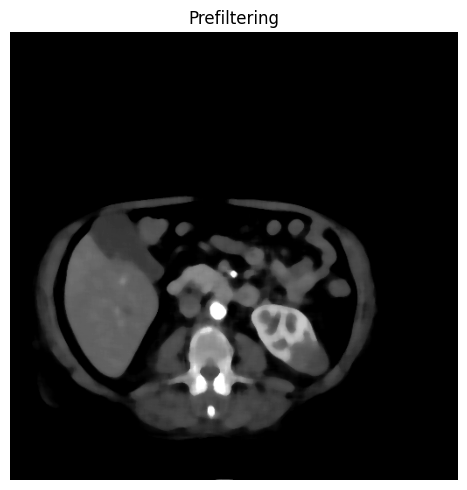

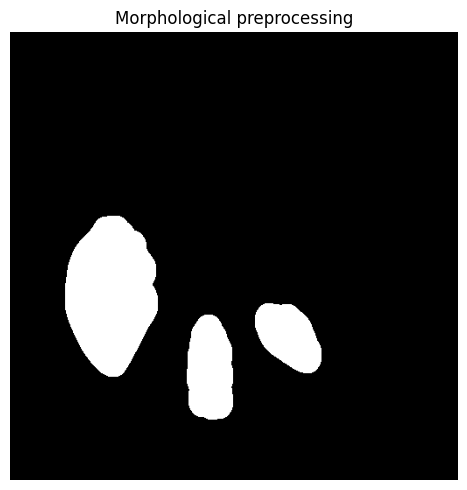

In [6]:
prefiltered_image = prefilter_image(original_image, size=PRE_MEDIAN_FILTER, equalize=PRE_EQ, clip_limit=PRE_CLIP_LIMIT)
display_images([prefiltered_image], ['Prefiltering'])

premorpho_image = morphological_preprocessing(prefiltered_image, se_width=PRE_MORPHO_SE_W,
                                              se_height=PRE_MORPHO_SE_H, thresh_val=PRE_MORPHO_THRESH,
                                                min_size=PRE_MORPHO_THRESH_MIN_SIZE,
                                                connectivity=PRE_MORPHO_THRESH_CONN, area_threshold=PRE_MORPHO_THRESH_AREA)
display_images([premorpho_image], ['Morphological preprocessing'])

### Segmentation

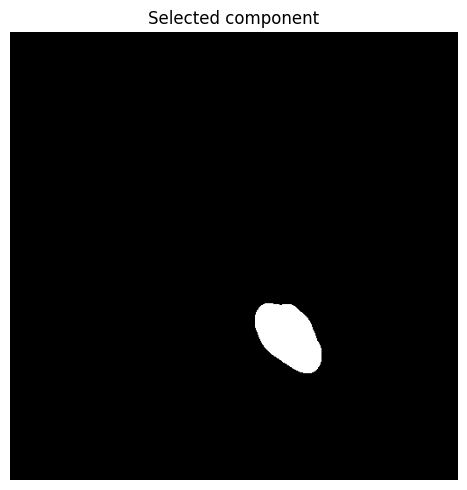

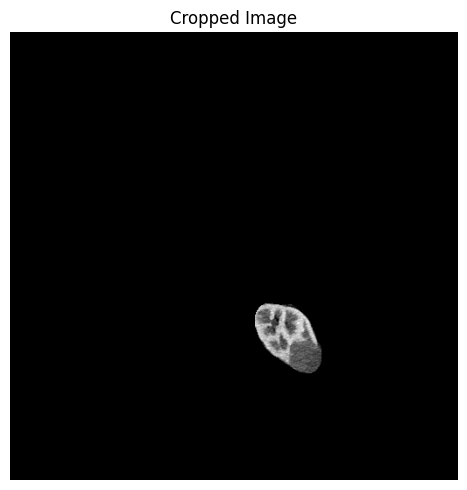

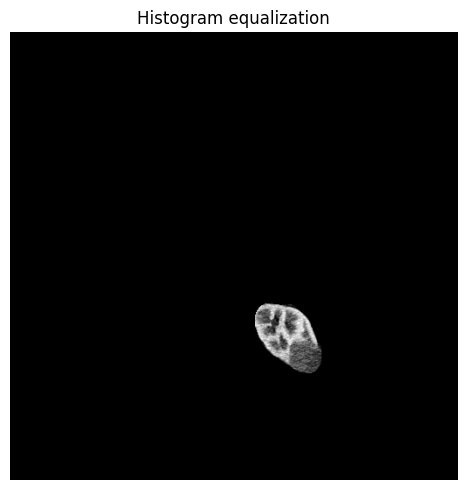

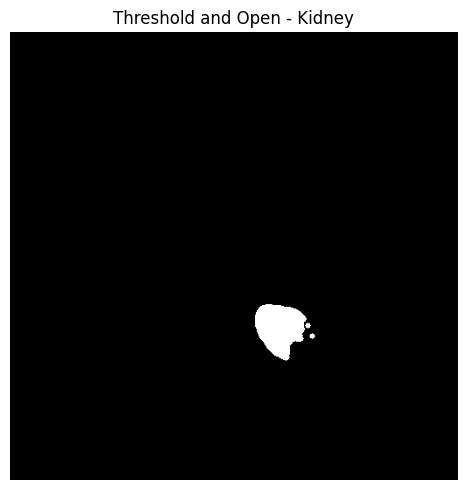

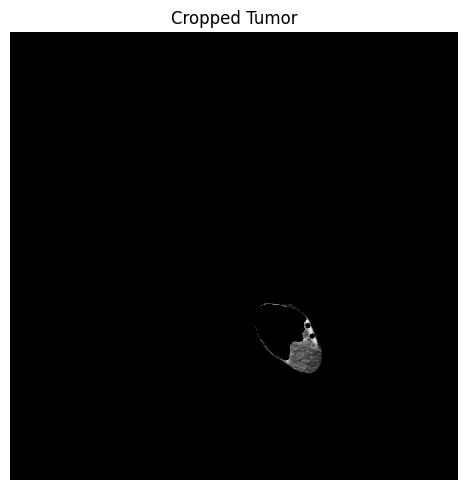

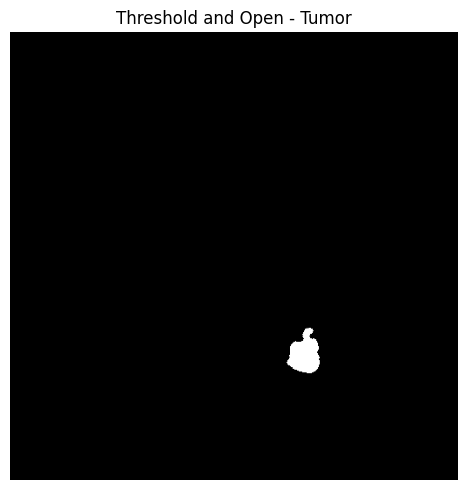

In [7]:
#processed_image = select_component(premorpho_image, side=SIDE)
processed_image = keep_smallest_connex_area(premorpho_image)
display_images([processed_image], ['Selected component'])

cropped_image = crop_image(original_image, processed_image)
display_images([cropped_image], ['Cropped Image'])

cropped_image = enhance_contrast(cropped_image, CLIP_LIMIT)
display_images([cropped_image], ['Histogram equalization'])

# Apply Otsu method for adaptively finding thresholds
thresholds = threshold_multiotsu(cropped_image)
thres_1 = thresholds[1]
thresh_2 = thresholds[0]

# Apply threshold and open operations
seg_thresh_test_1 = threshold_and_open(cropped_image, thres_1,
                                        min_size=MORPHO_THRESH_MIN_SIZE, area_threshold=MORPHO_THRESH_AREA,
                                          connectivity=MORPHO_THRESH_CONN, disk_size=MORPHO_THRESH_RADIUS)
display_images([seg_thresh_test_1], ['Threshold and Open - Kidney'])

cropped_tum = crop_image(cropped_image, 1 - seg_thresh_test_1)
display_images([cropped_tum], ['Cropped Tumor'])

seg_thresh_test_2 = threshold_and_open(cropped_tum, thresh_2,
                                        min_size=MORPHO_THRESH_MIN_SIZE, area_threshold=MORPHO_THRESH_AREA,
                                          connectivity=MORPHO_THRESH_CONN, disk_size=MORPHO_THRESH_RADIUS)
display_images([seg_thresh_test_2], ['Threshold and Open - Tumor'])

### Post-processing

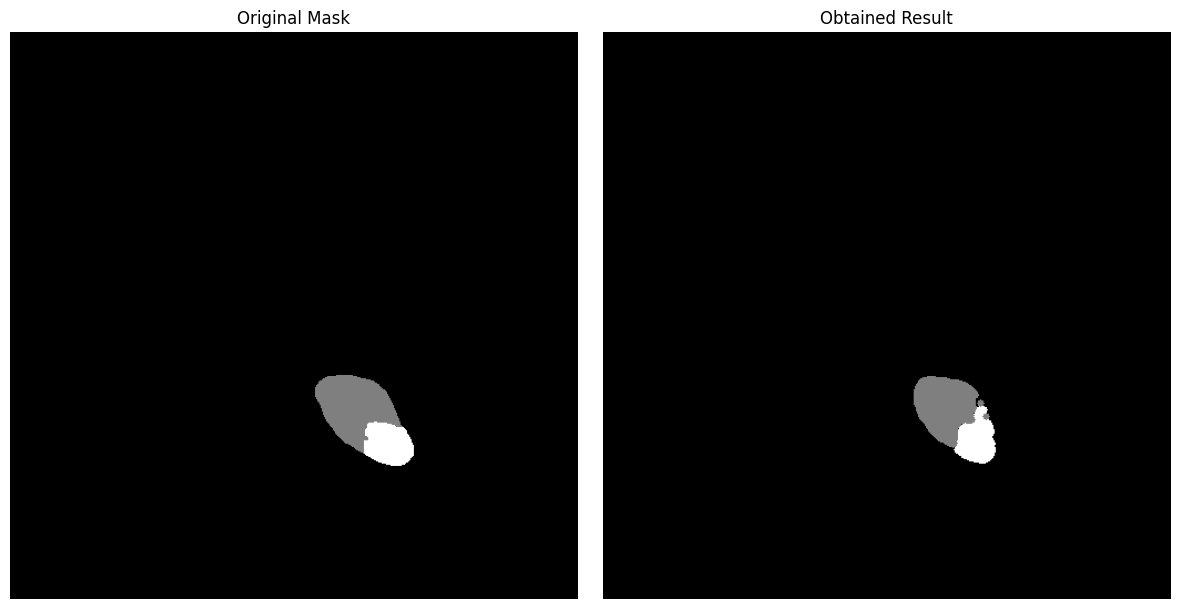

In [8]:
result = combine_masks(seg_thresh_test_1, seg_thresh_test_2, label_1=LABEL_KIDNEY, label_2=LABEL_TUMOR)

# Display the final result alongside the original mask
display_images([labels_image, result], ['Original Mask', 'Obtained Result'], size=(12, 6))

### Evaluation

The kidney is well detected in both examples, but the tumor size in the second example is underestimated. 

In [9]:
print("Dice Coefficient for kidney:", compute_dice(result, labels_image, label=LABEL_KIDNEY))
print("Dice Coefficient for tumor:", compute_dice(result, labels_image, label=LABEL_TUMOR))

Dice Coefficient for kidney: 0.9045346062052506
Dice Coefficient for tumor: 0.7964272422776331


## Brain MRI

This pipeline is working for examples indexed `0` and `3`. The logic followed is explained below.

#### Preprocessing

We applied the histogram of a reference image to all the images to be segmented, in order to make the threshold value more similar for each of them; however, we still 'hardcoded' this parameter to (90 for image 0 and 60 for the others).

Then, we applied the k-means algorithm to this image using 10 'clusters', because when we used a larger part of our object to segment, it was classified into different clusters, and when we used a smaller part of our target to segment, it was joined to parts of its environment.

#### Algorithm

We calculate the area, perimeter, and centroid of any of the 'ground truth masks'.

Once the preprocessing is applied, we obtain the result of the application of K-Means (however, given the nature of the k-means algorithm, it is possible to obtain different groups with the same parameters, which sometimes leads to poor segmentation). We then set a target intensity value and obtain the K-Means label closest to this value.

Once the appropriate label is obtained, we get different figures. For each figure, we will calculate its area, perimeter, and centroid in order to compare these values with those of the chosen 'ground truth mask'. We will choose the figure that shows the smallest difference in these values.

#### Post-processing

Given that by using k-means, our object to be segmented took small parts of its environment, which made it appear larger than it actually is, we used the "closing" operation to further refine its size.

#### Evaluation

We use the DICE similarity coefficient.

### Function definitions

In [10]:
def extract_images(input_img, components):
    """
    Extracts separate images for each component in the input image.
    """
    result_imgs = [np.zeros(input_img.shape) for _ in components]
    for idx, component in enumerate(components):
        for x, y in component:
            result_imgs[idx][x][y] = 1
    return result_imgs

def get_components(binary_img):
    """
    Identifies and returns the distinct components in a binary image.
    """
    rows, cols = binary_img.shape
    already_seen = np.zeros_like(binary_img, dtype=bool)
    components = []

    for row in range(rows):
        for col in range(cols):
            if binary_img[row, col] == 1 and not already_seen[row, col]:
                component = []
                queue = deque([(row, col)])
                already_seen[row, col] = True

                while queue:
                    r, c = queue.popleft()
                    component.append((r, c))
                    for dr, dc in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                        r_, c_ = r + dr, c + dc
                        if 0 <= r_ < rows and 0 <= c_ < cols and binary_img[r_, c_] == 1 and not already_seen[r_, c_]:
                            queue.append((r_, c_))
                            already_seen[r_, c_] = True
                components.append(component)
    return components

def get_image_area(binary_img):
    """
    Calculates the area of the shapes in the binary image.
    """
    return np.count_nonzero(binary_img)

def get_image_perimeter(binary_img):
    """
    Calculates the perimeter of the shapes in the binary image.
    """
    contour = find_contours(binary_img.clip(max=1))[0]
    return len(contour)

def get_image_centroid(binary_img):
    """
    Calculates the centroid of the shapes in the binary image.
    """
    coords = np.argwhere(binary_img.clip(max=1) == 1)
    return np.mean(coords, axis=0).astype(int)

def extract_features(input_image):
    """
    Extracts features such as centroid, perimeter, and area from each shape in the image.
    """
    components_list = get_components(input_image)
    component_images = extract_images(input_image, components_list)
    features_list = []

    for temp_image in component_images:
        centroid = get_image_centroid(temp_image)
        perimeter = get_image_perimeter(temp_image)
        area = get_image_area(temp_image)
        features_list.append((centroid, perimeter, area))

    return features_list, component_images

def get_most_probable_shape(ref_selectors, test_features):
    """
    Identifies the most probable shape matching the reference selectors from the test features.
    """
    ref_centroid, ref_perimeter, ref_area = ref_selectors[0]
    x_ref, y_ref = ref_centroid
    ref_total_score = ref_perimeter + ref_area

    features_params = []
    for test_centroid, test_perimeter, test_area in test_features:
        x_test, y_test = test_centroid
        distance_squared = (x_test - x_ref)**2 + (y_test - y_ref)**2
        test_total_score = test_perimeter + test_area
        score_diff = abs(ref_total_score - test_total_score)
        features_params.append([distance_squared, score_diff])
    
    features_params_array = np.array(features_params)
    half_len = len(features_params_array) // 2
    selected_by_distance = np.argpartition(features_params_array[:, 0], half_len)[:half_len]
    selected_index = np.argmin(features_params_array[selected_by_distance, 1])

    return selected_by_distance[selected_index]

def plot_image_results(Img_brain_test, Seg_thresh_test, Seg_km_test, Seg_km_labels_test, image, nber_clusters):
    """
    Plot and display the results of image processing including the source MRI, thresholded MRI,
    k-means centers, and k-means labels for a given image.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    ax = axes.ravel()

    for a in ax:
        a.axis('off')

    ax[0].imshow(Img_brain_test, cmap='gray')
    ax[0].set_title('Source MRI')
    ax[1].imshow(Seg_thresh_test, cmap='gray')
    ax[1].set_title('Thresholded MRI')

    tmp = ax[3].imshow(Seg_km_test, cmap='nipy_spectral')
    fig.colorbar(tmp, ax=ax[3], orientation='vertical')
    ax[3].set_title('kmeans Centers image ' + str(image))

    tmp = ax[2].imshow(Seg_km_labels_test, cmap='nipy_spectral')
    fig.colorbar(tmp, ax=ax[2], orientation='vertical')
    ax[2].set_title('kmeans labels image '  + str(image))

    fig.tight_layout()
    plt.show()

def calculate_label_means(Img_brain_test, Seg_km_labels_test, nber_clusters):
    """
    Calculate the mean intensity values for each label in the k-means segmented image.
    """
    Img_label_means = np.empty(nber_clusters)
    for i in range(nber_clusters):
        Img_label_mask = Seg_km_labels_test == i
        Img_label_mask = Img_label_mask.astype('uint8')
        tmp = cv2.mean(Img_brain_test, Img_label_mask)
        Img_label_means[i] = tmp[0]
    return Img_label_means

def select_label(Img_label_means, Img_brain_test, Seg_thresh_test, nber_clusters):
    """
    Select the label from the k-means segmentation that is closest to the target value based on intensity.
    """
    Target_value = cv2.mean(Img_brain_test, Seg_thresh_test)[0]
    Diff = np.absolute(Img_label_means - Target_value * np.ones(nber_clusters))
    return np.argmin(Diff)

def process_segmentation_mask(Seg_km_labels_test, Label_select):
    """
    Process the segmentation mask by selecting the specific label and converting it to a binary mask.
    """
    Img_label_select = Seg_km_labels_test == Label_select
    Img_label_select = Img_label_select.astype('float64')
    return Img_label_select

def refine_segmentation_mask(Img_label_select):
    """
    Refine the segmentation mask by applying a Gaussian filter and morphological operations to clean up small objects and holes.
    """
    Img_label_select_smooth = gaussian(Img_label_select, 2, preserve_range=True)
    Img_label_select_smooth_clean = morphology.remove_small_holes(
        morphology.remove_small_objects(
            Img_label_select_smooth > 0.25, min_size=50, connectivity=1),
        area_threshold=50)
    return Img_label_select_smooth, Img_label_select_smooth_clean

def plot_refined_segmentation(Img_label_select, Img_label_select_smooth, Img_label_select_smooth_clean, Seg_brain_test):
    """
    Plot and display the refined segmentation results including the selected cluster, smoothened cluster, 
    processed with morphology, and the target feature.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    ax = axes.ravel()

    ax[0].imshow(Img_label_select, cmap='gray')
    ax[0].set_title('Selected cluster')
    ax[1].imshow(Img_label_select_smooth, cmap='gray')
    ax[1].set_title('Smoothened cluster')
    ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
    ax[2].set_title('Processed with morpho')
    ax[3].imshow(Seg_brain_test, cmap='gray')
    ax[3].set_title('Target feature')

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

def apply_morphological_closing(selected_image):
    """
    Apply morphological closing to the selected image using a disk-shaped structuring element.
    """
    Radius = 3
    se = morphology.disk(Radius)
    return morphology.closing(selected_image, se)

def plot_final_results(Img_brain_test, selected_image, Seg_brain_test, image, test_mask):
    """
    Plot and display the final results including the original image, mask of the image, expected feature,
    and the extracted feature of the given image.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    ax = axes.ravel()

    ax[0].imshow(Img_brain_test, cmap='gray')
    ax[0].set_title('Original image ' + str(image))

    ax[1].imshow(Img_brain_test, cmap='gray')
    for contour in test_mask:
        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=4, c='r')
    ax[1].set_title('Mask of image ' + str(image))

    ax[2].imshow(Seg_brain_test, cmap='gray')
    ax[2].set_title('Expected feature')

    ax[3].imshow(selected_image, cmap='gray')
    ax[3].set_title('Extracted feature of image ' + str(image))

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

def calculate_dice_similarity(Seg_brain_test, selected_image):
    """
    Calculate the Dice similarity coefficient between the segmented brain test image and the selected image.
    """
    return np.sum(Seg_brain_test == selected_image) * 2.0 / (np.sum(Seg_brain_test) + np.sum(selected_image))

### Load images

In [11]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')

selected_images = [0,3]

There are 4 brain MRI images


### Hyperparameters

In [12]:
INDEX_REF = 0
NBER_CLUSTERS = 10
TARGET_VALUE_THRESH_0 = 90
TARGET_VALUE_THRESH_OTHERS = 60
MIN_SIZE = 500
AREA_THRESHOLD = 500
MORPHOLOGY_DISK_SIZE = 3
CONTOUR_LEVEL = 0.8

### Pipeline

filename c:\Users\carlos\Downloads\GitHub\telecom-ima204-segmentation/data/brainMRI\MRIs1.png


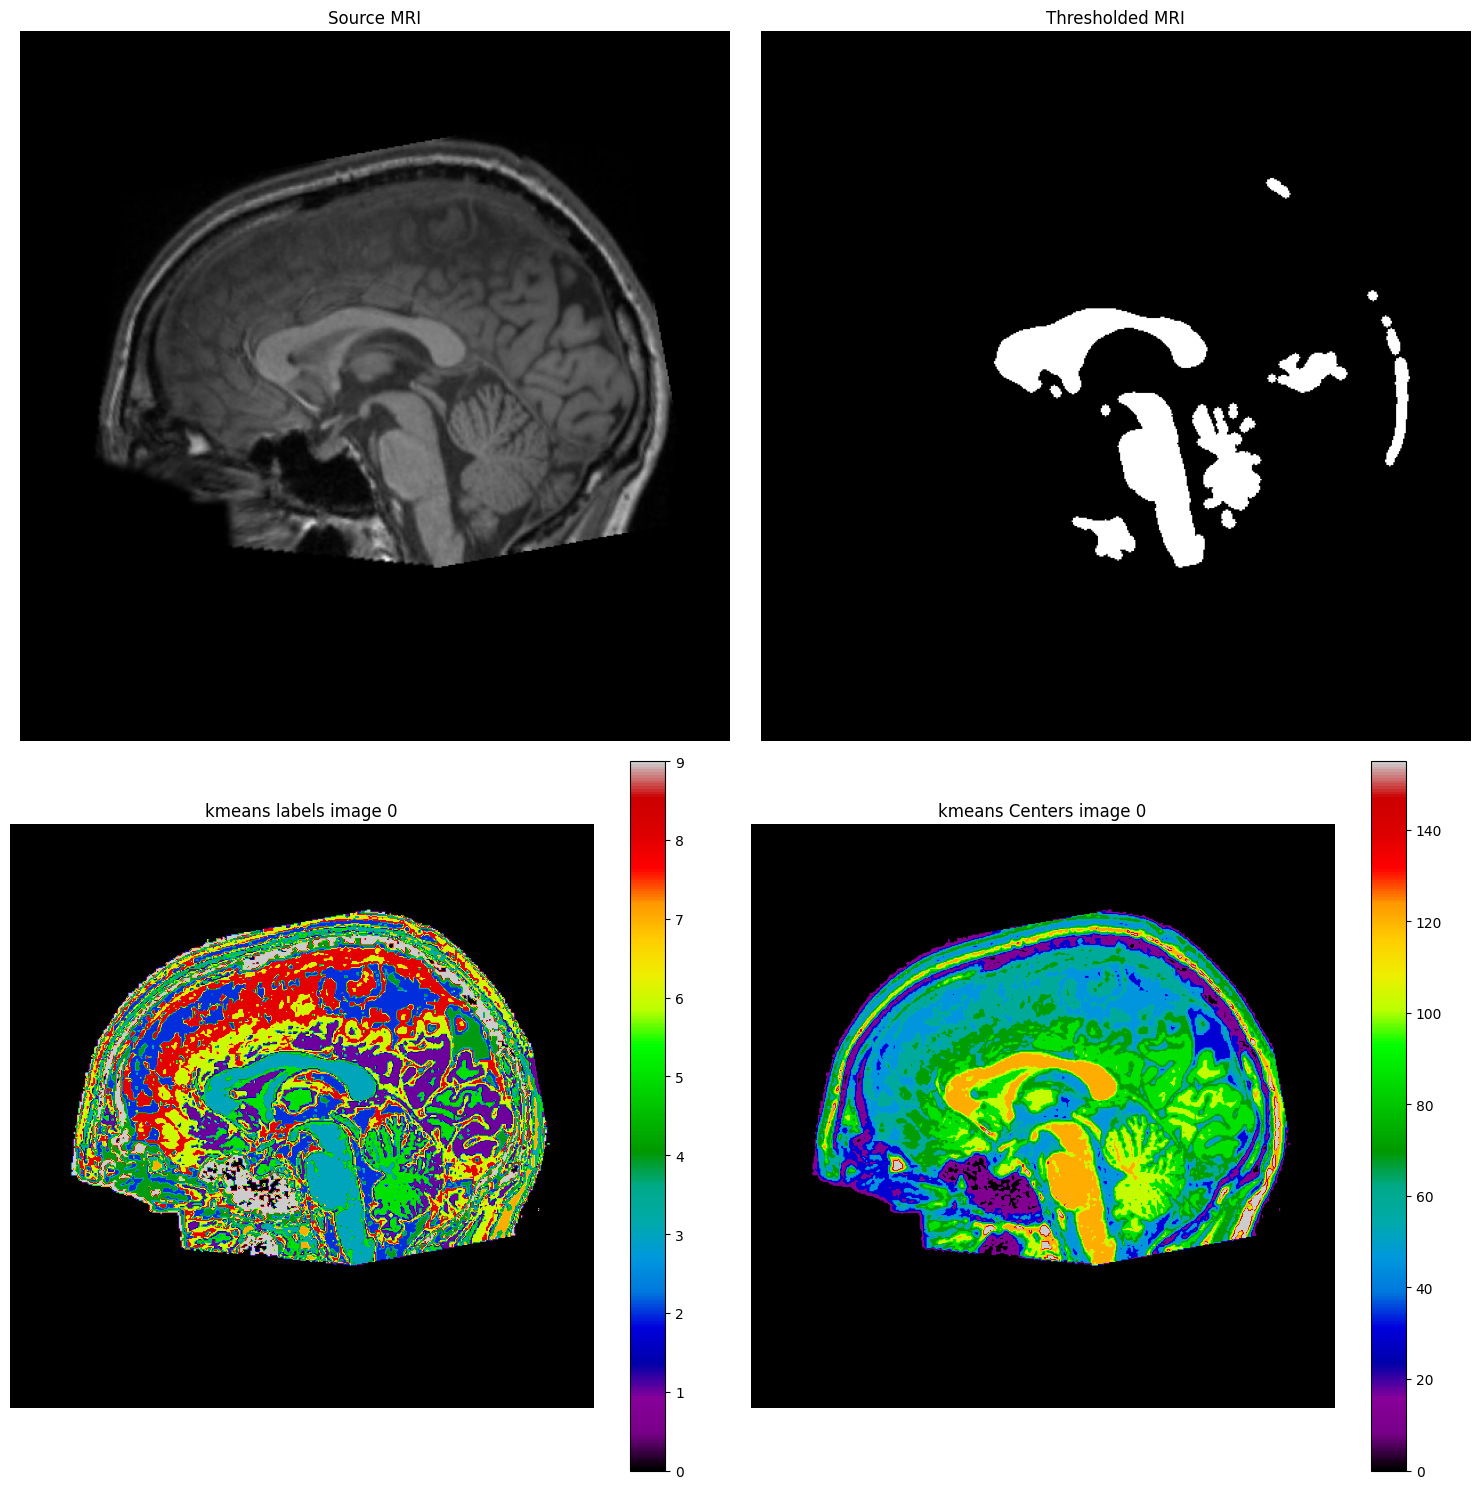

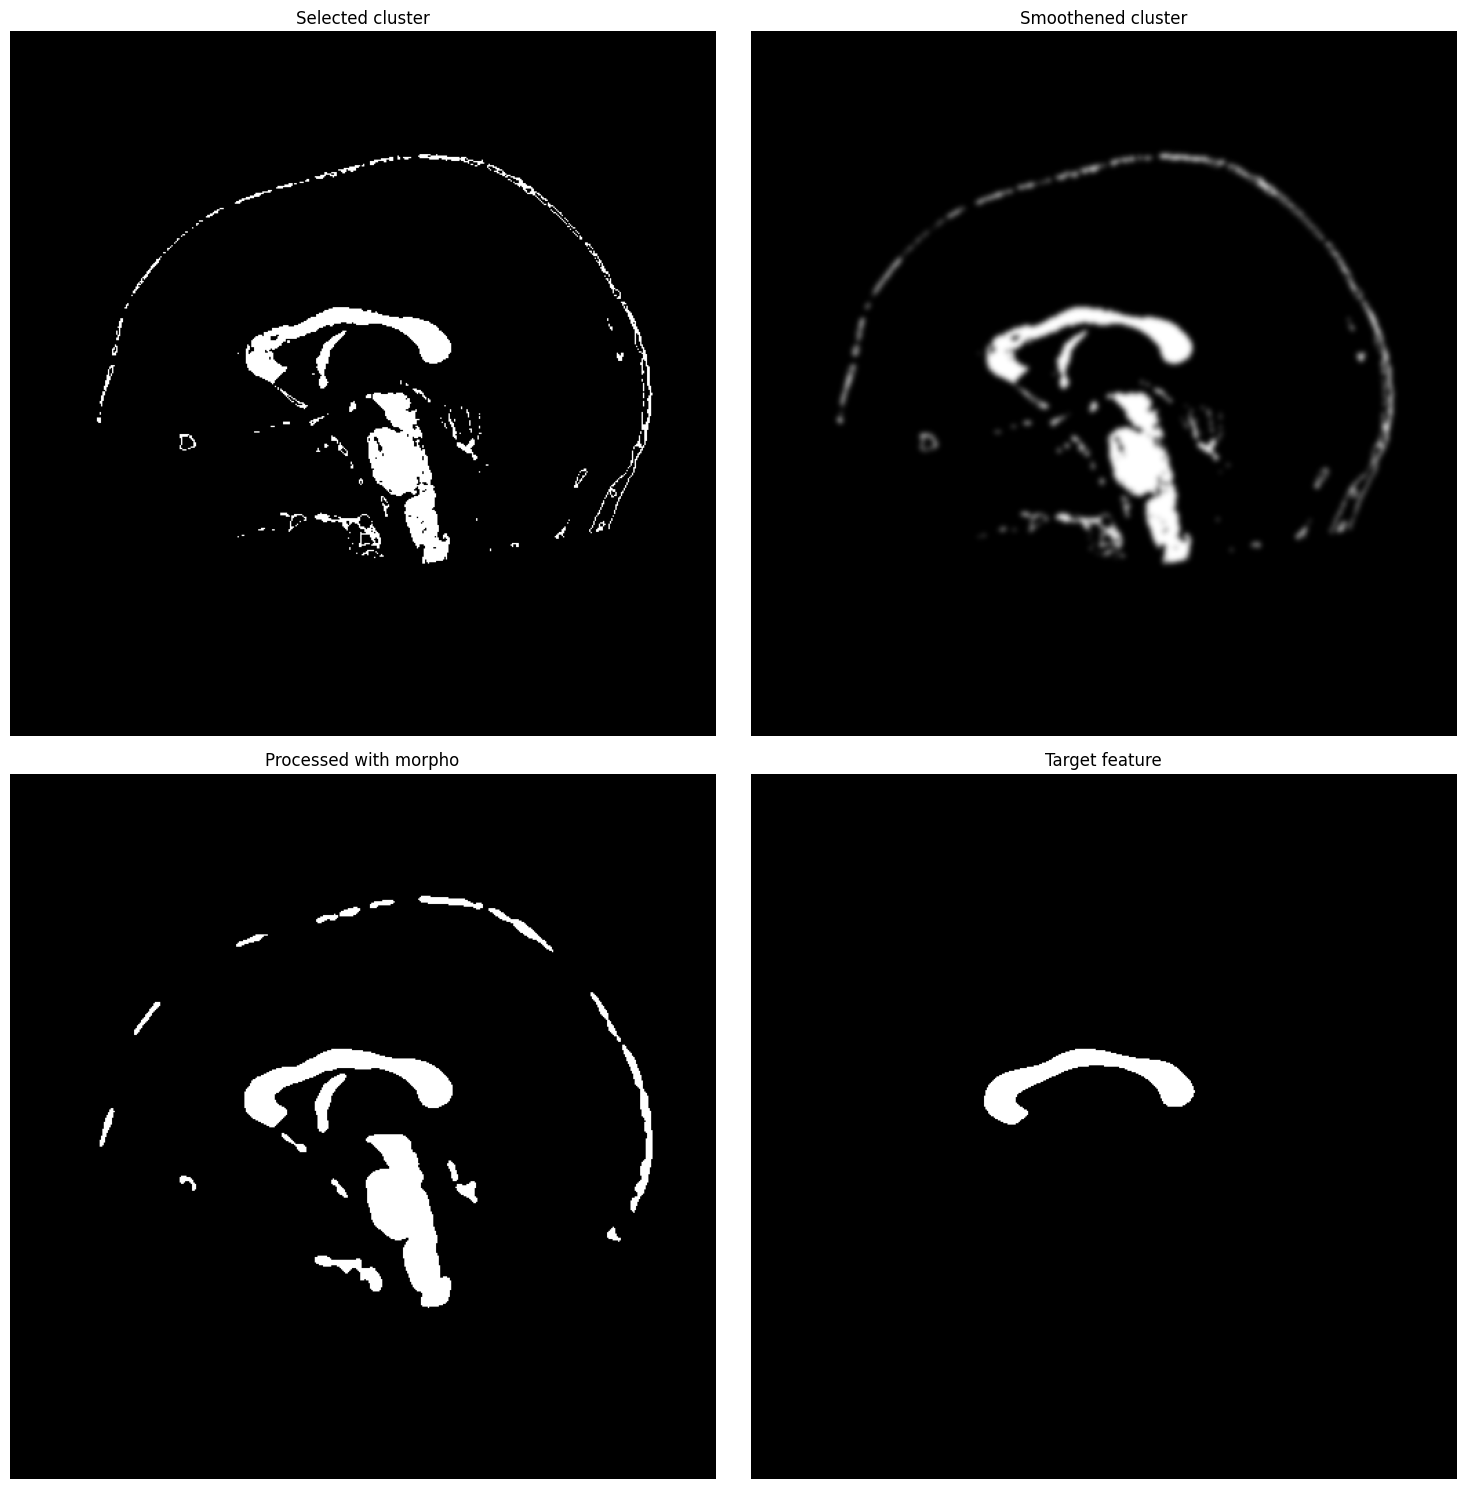

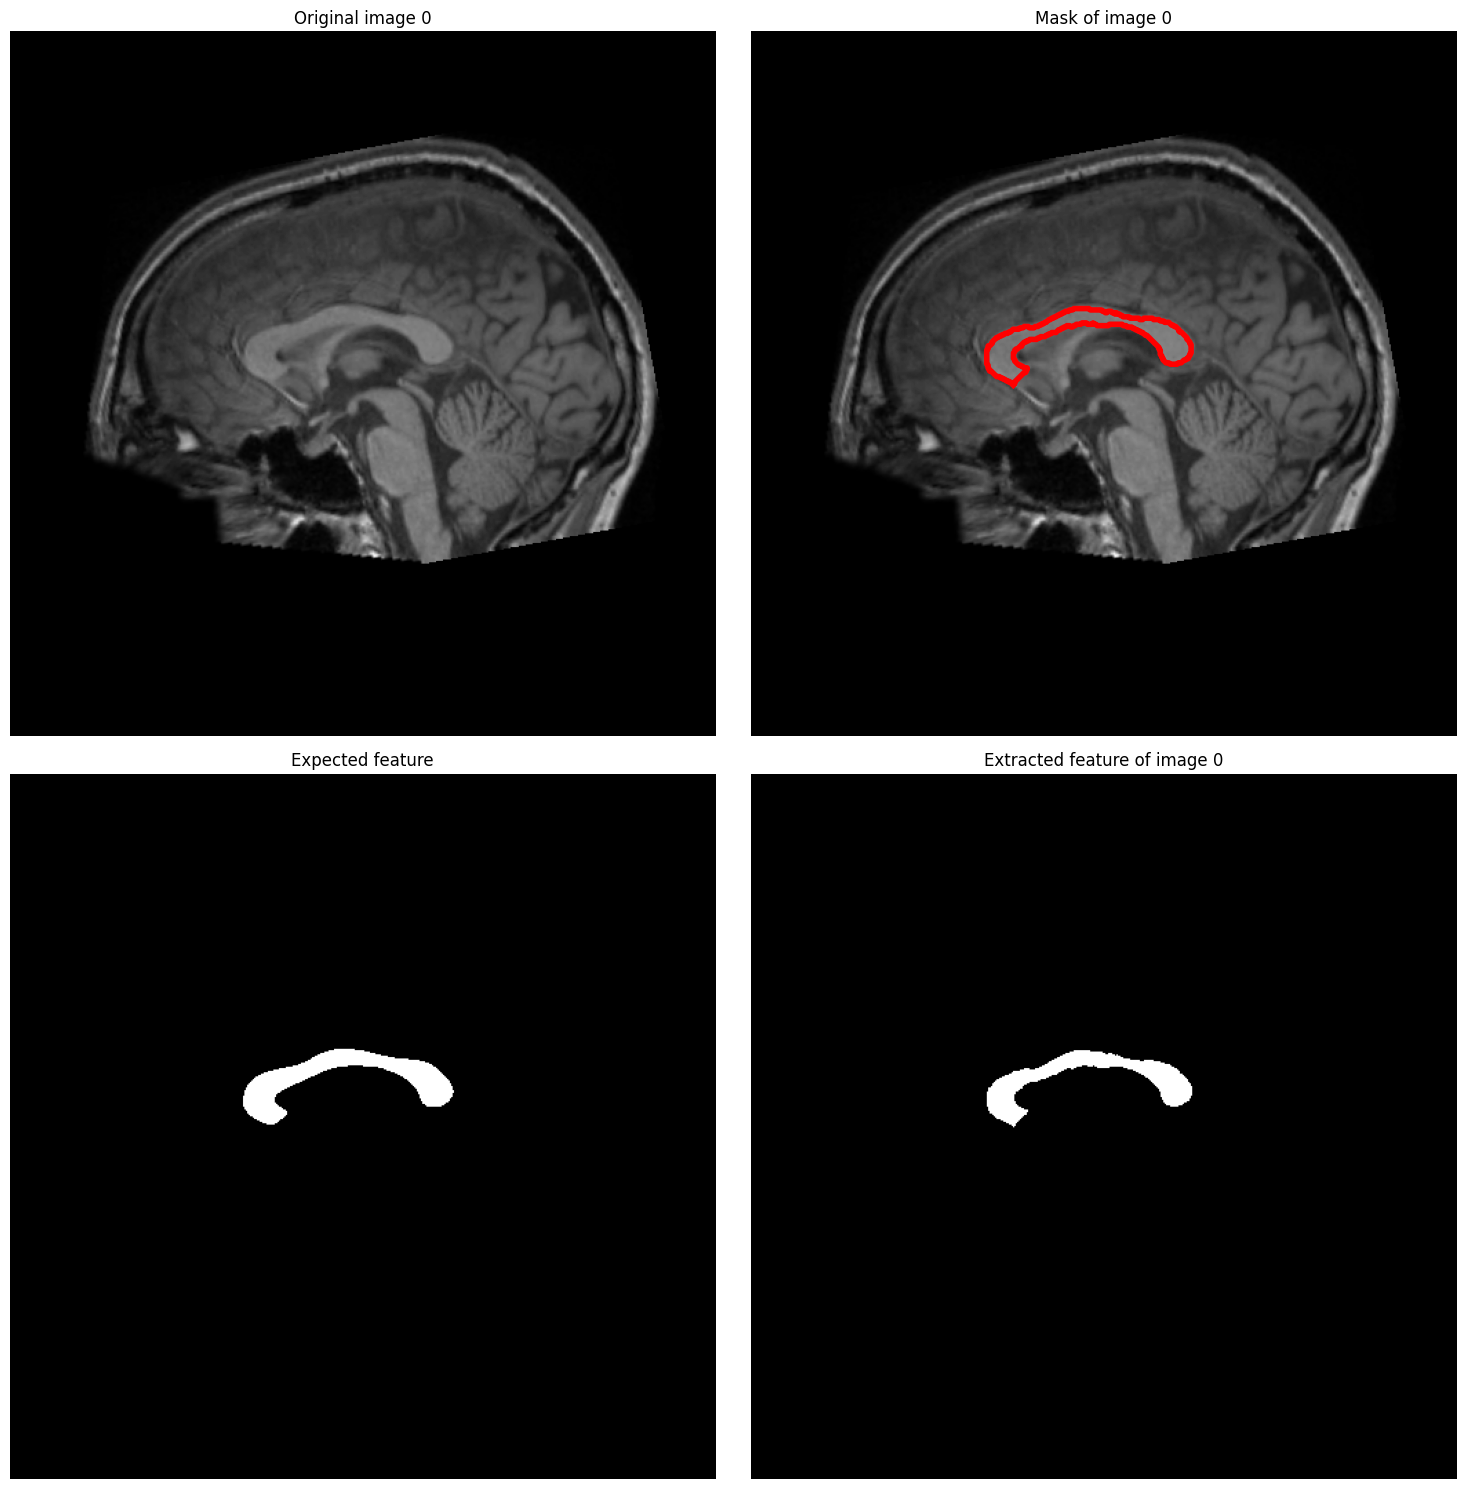

Dice similarity for image 0 = 0.9177239523260284
filename c:\Users\carlos\Downloads\GitHub\telecom-ima204-segmentation/data/brainMRI\MRIs4.png


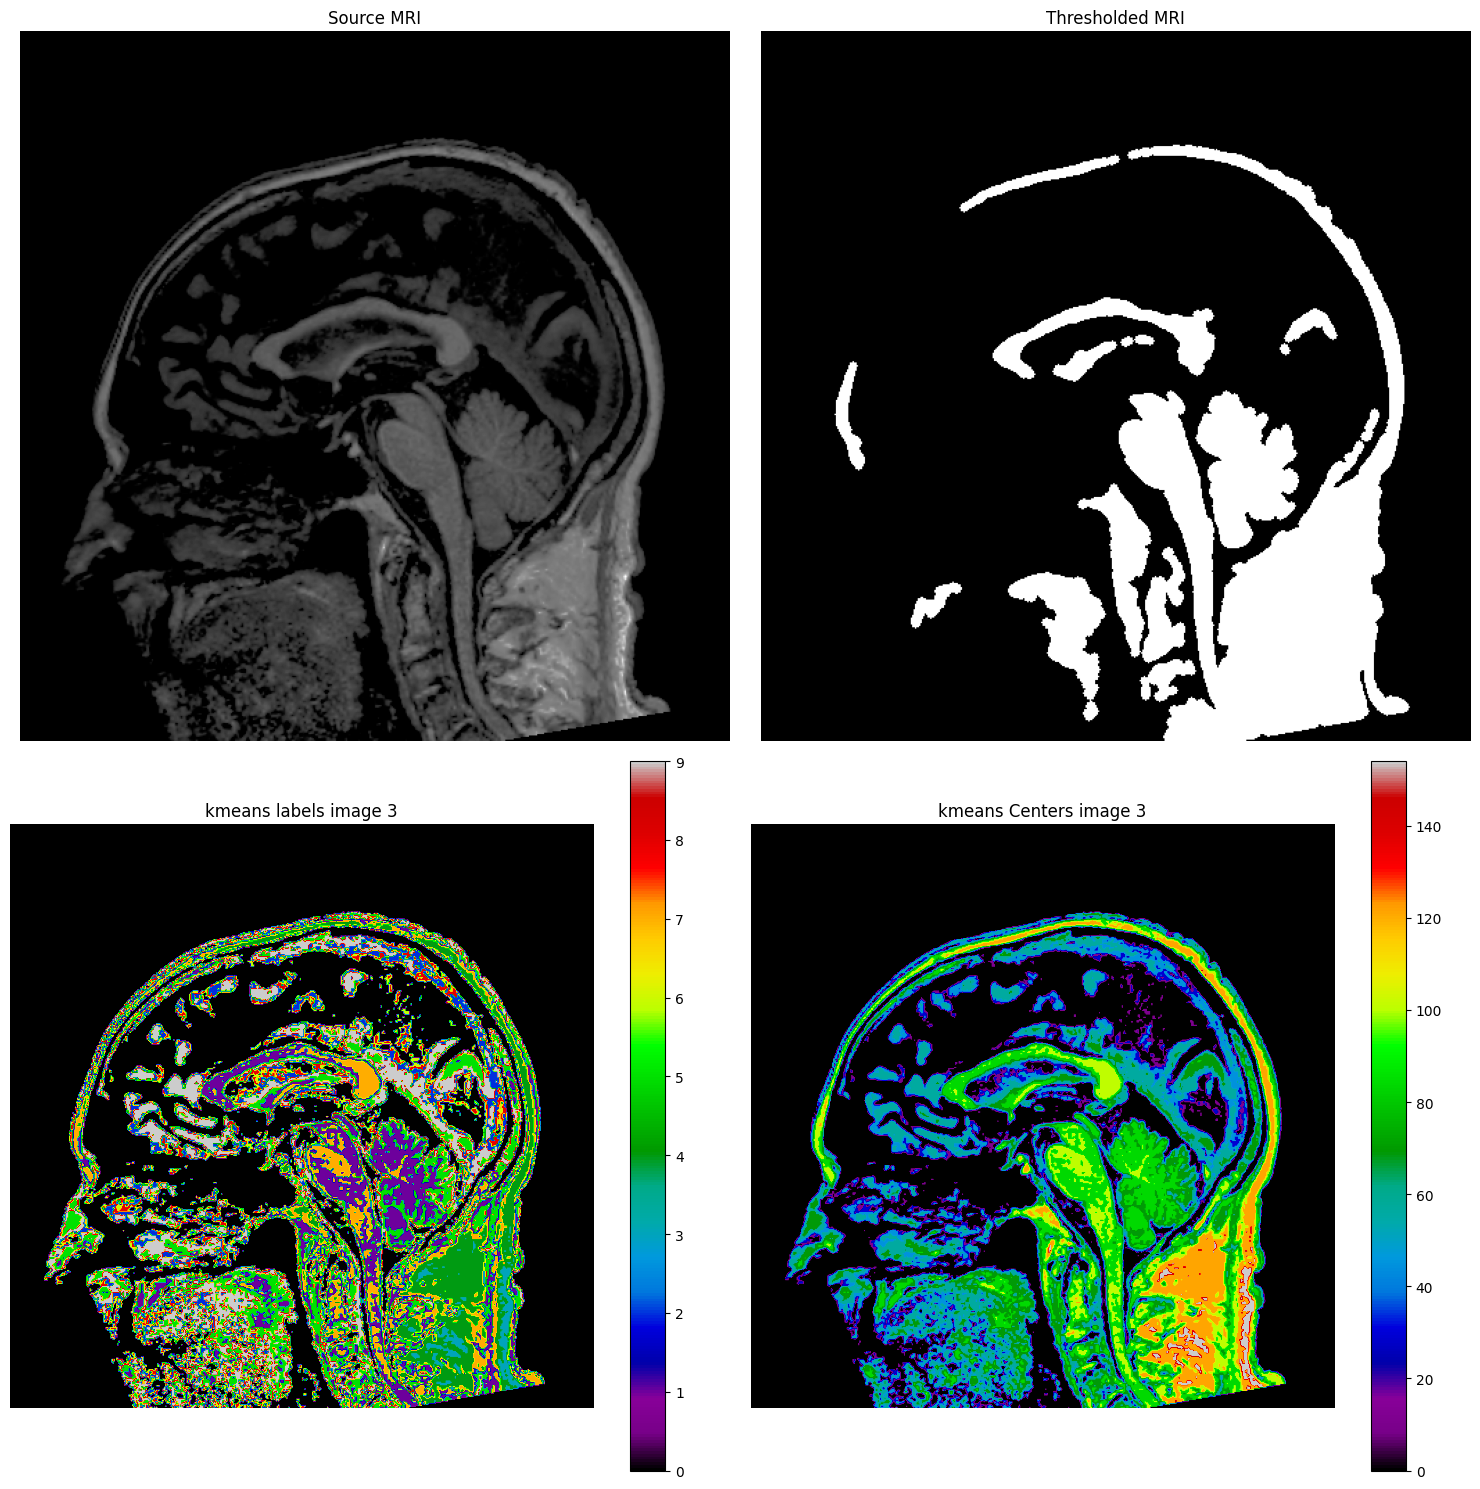

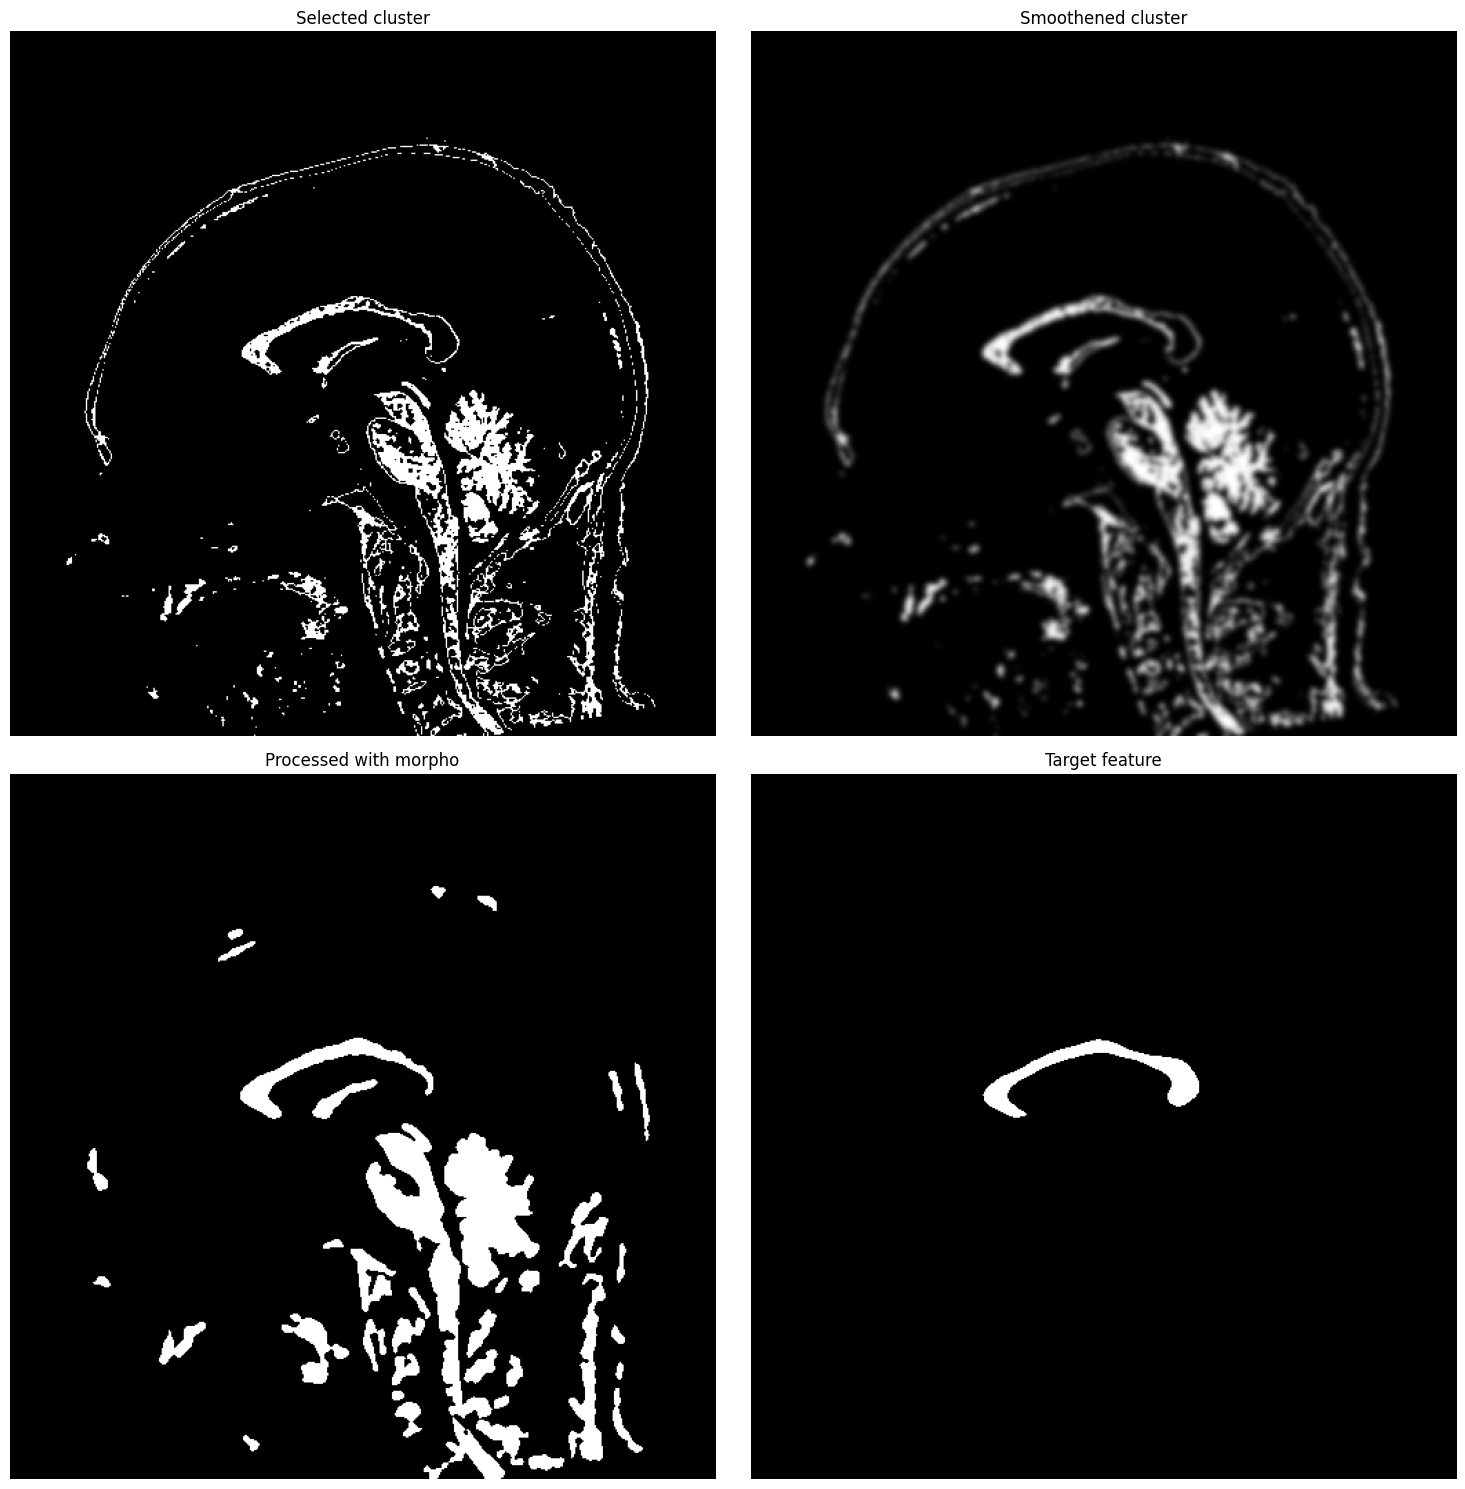

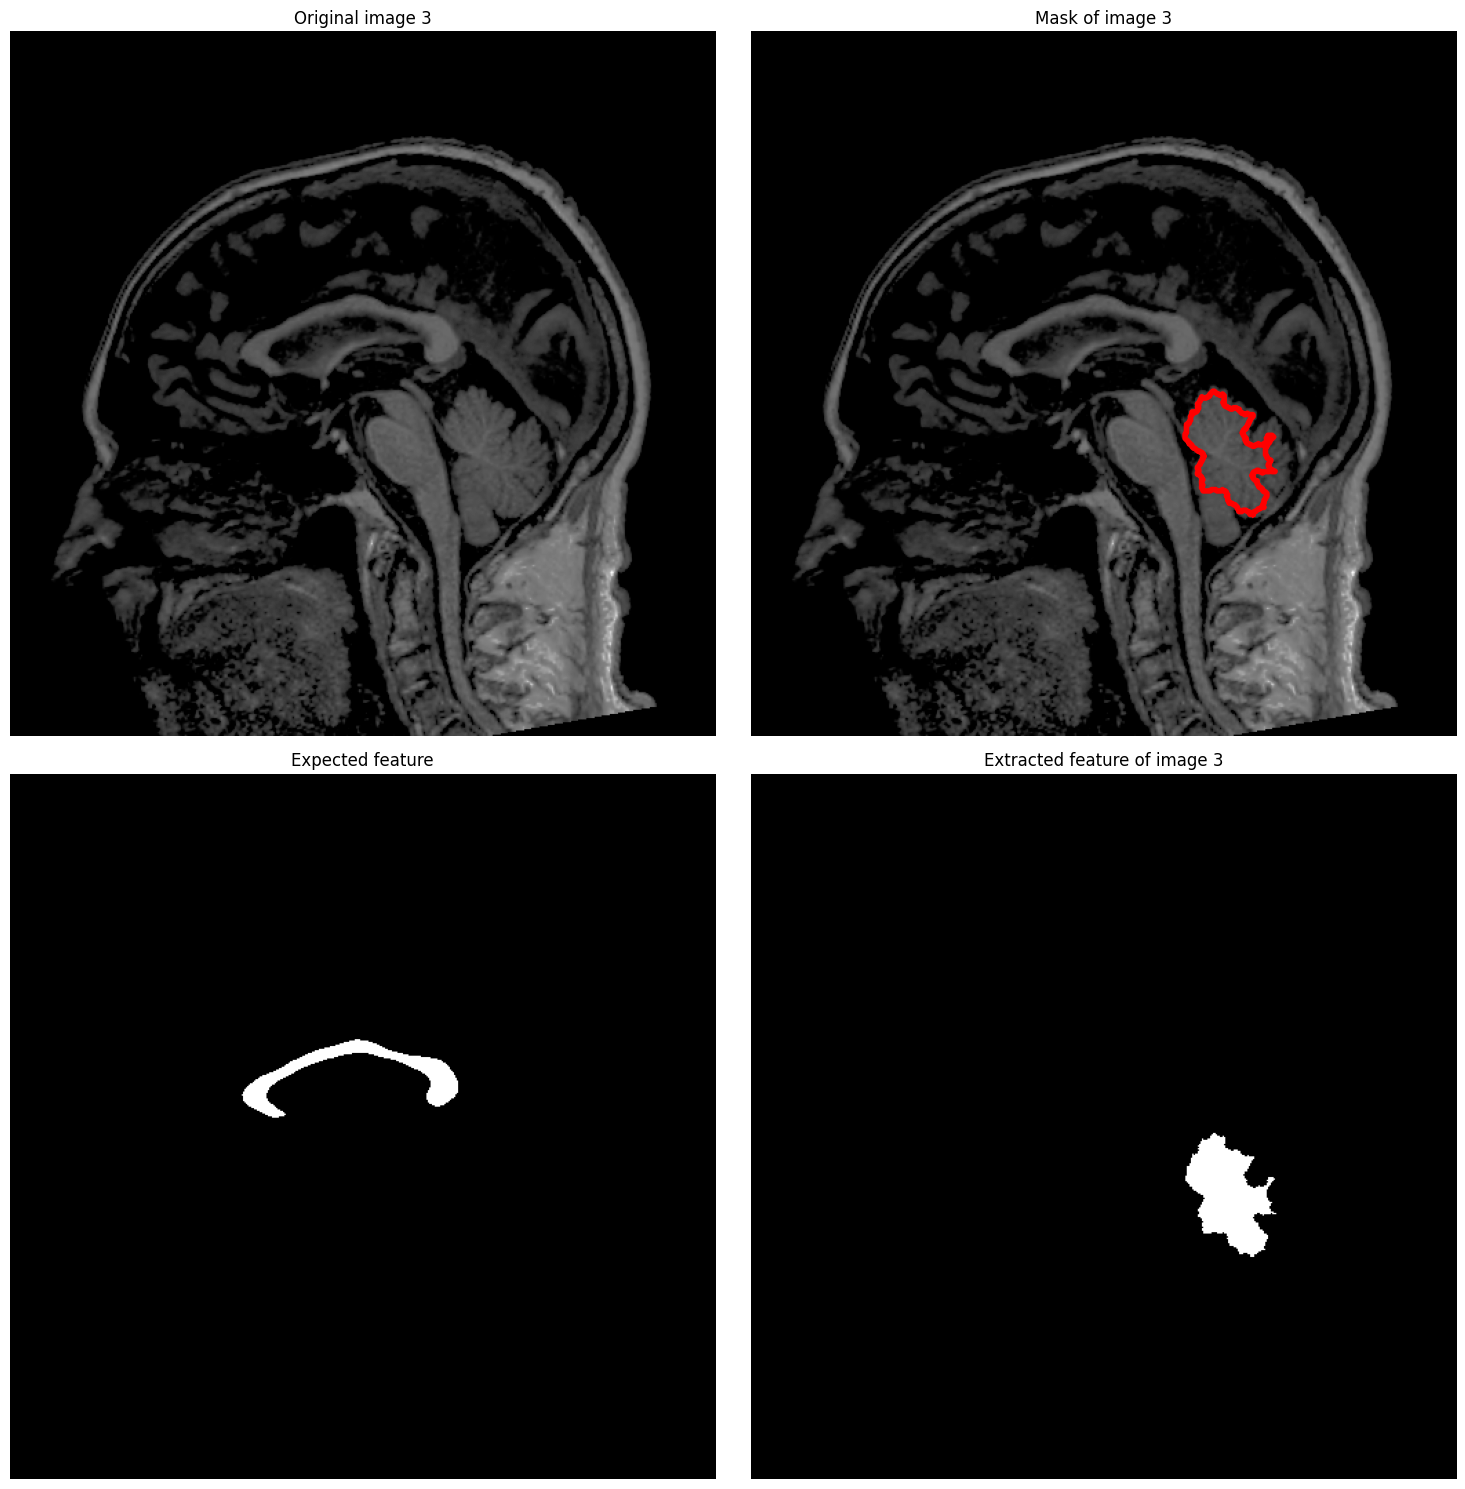

Dice similarity for image 3 = 0.0


In [13]:
for image in selected_images:
    ################################### Reference Image Selection
    filename_seg = listImagesbrainMRI[INDEX_REF]
    Seg_brain_ref = imread(filename_seg)
    filename = filename_seg[:-8] + '.png'
    Img_brain_ref = imread(filename)
    Img_brain_ref_normalized = Img_brain_ref / np.max(Img_brain_ref)

    ####################################### Reference Image Properties
    ref_centroid = get_image_centroid(Seg_brain_ref)
    ref_perimeter = get_image_perimeter(Seg_brain_ref)
    ref_area = get_image_area(Seg_brain_ref)

    ####################################### Process New Image
    indexIm_ref = image
    filename_seg = listImagesbrainMRI[indexIm_ref]
    Seg_brain_test = imread(filename_seg)
    filename = filename_seg[:-8] + '.png'
    print('filename ' + str(filename))
    Img_brain_test = imread(filename)

    ########################################## Preprocessing: Histogram Equalization and Median Filter
    Img_brain_test_normalized = Img_brain_test / np.max(Img_brain_test)
    matched_hist = exposure.match_histograms(Img_brain_test_normalized, Img_brain_ref_normalized)
    Img_brain_test = matched_hist * np.max(Img_brain_test)

    ########################################## Preprocessing: k-Means Clustering
    Target_value_thresh = TARGET_VALUE_THRESH_0 if image == 0 else TARGET_VALUE_THRESH_OTHERS
    Seg_km_test, Seg_km_labels_test = my_kmeans(Img_brain_test, NBER_CLUSTERS)
    Colormap = plt.get_cmap('nipy_spectral', NBER_CLUSTERS)

    ######################################### Thresholded Image Processing
    Seg_thresh_test = morphology.remove_small_holes(
        morphology.remove_small_objects(
            (Img_brain_test > Target_value_thresh) & (Img_brain_test < 150),
            min_size=MIN_SIZE, connectivity=1),
        area_threshold=AREA_THRESHOLD).astype('uint8')
    Seg_thresh_test = morphology.opening(Seg_thresh_test, morphology.disk(MORPHOLOGY_DISK_SIZE))

    # Plotting results
    plot_image_results(Img_brain_test, Seg_thresh_test, Seg_km_test, Seg_km_labels_test, image, NBER_CLUSTERS)

    ########################################## Image Label Processing
    Img_label_means = calculate_label_means(Img_brain_test, Seg_km_labels_test, NBER_CLUSTERS)
    Label_select = select_label(Img_label_means, Img_brain_test, Seg_thresh_test, NBER_CLUSTERS)

    # Generate and process binary segmentation mask
    Img_label_select = process_segmentation_mask(Seg_km_labels_test, Label_select)
    
    # Further refine segmentation mask
    Img_label_select_smooth, Img_label_select_smooth_clean = refine_segmentation_mask(Img_label_select)

    # Plotting refined segmentation results
    plot_refined_segmentation(Img_label_select, Img_label_select_smooth, Img_label_select_smooth_clean, Seg_brain_test)

    #################################################### Feature Extraction and Comparison
    im = Img_label_select.astype(int)
    
    ref_feature, ref_images = extract_features(Seg_brain_ref.clip(max=1))
    test_features, test_images = extract_features(im)
    selected_index = get_most_probable_shape(ref_feature, test_features)
    selected_image = test_images[selected_index]

    #################################################### Apply Morphological Closing
    selected_image = apply_morphological_closing(selected_image)

    # Find contours in the selected image
    test_mask = find_contours(selected_image, level=CONTOUR_LEVEL)

    # Plot final results
    plot_final_results(Img_brain_test, selected_image, Seg_brain_test, image, test_mask)

    # Calculate and print Dice similarity
    #Dice = calculate_dice_similarity(Seg_brain_test, selected_image)
    Dice = 1 - dice((Seg_brain_test > 0).astype(int).flatten(), (selected_image > 0).astype(int).flatten())
    print(f'Dice similarity for image {image} = {Dice}')
